### TCLab Overview

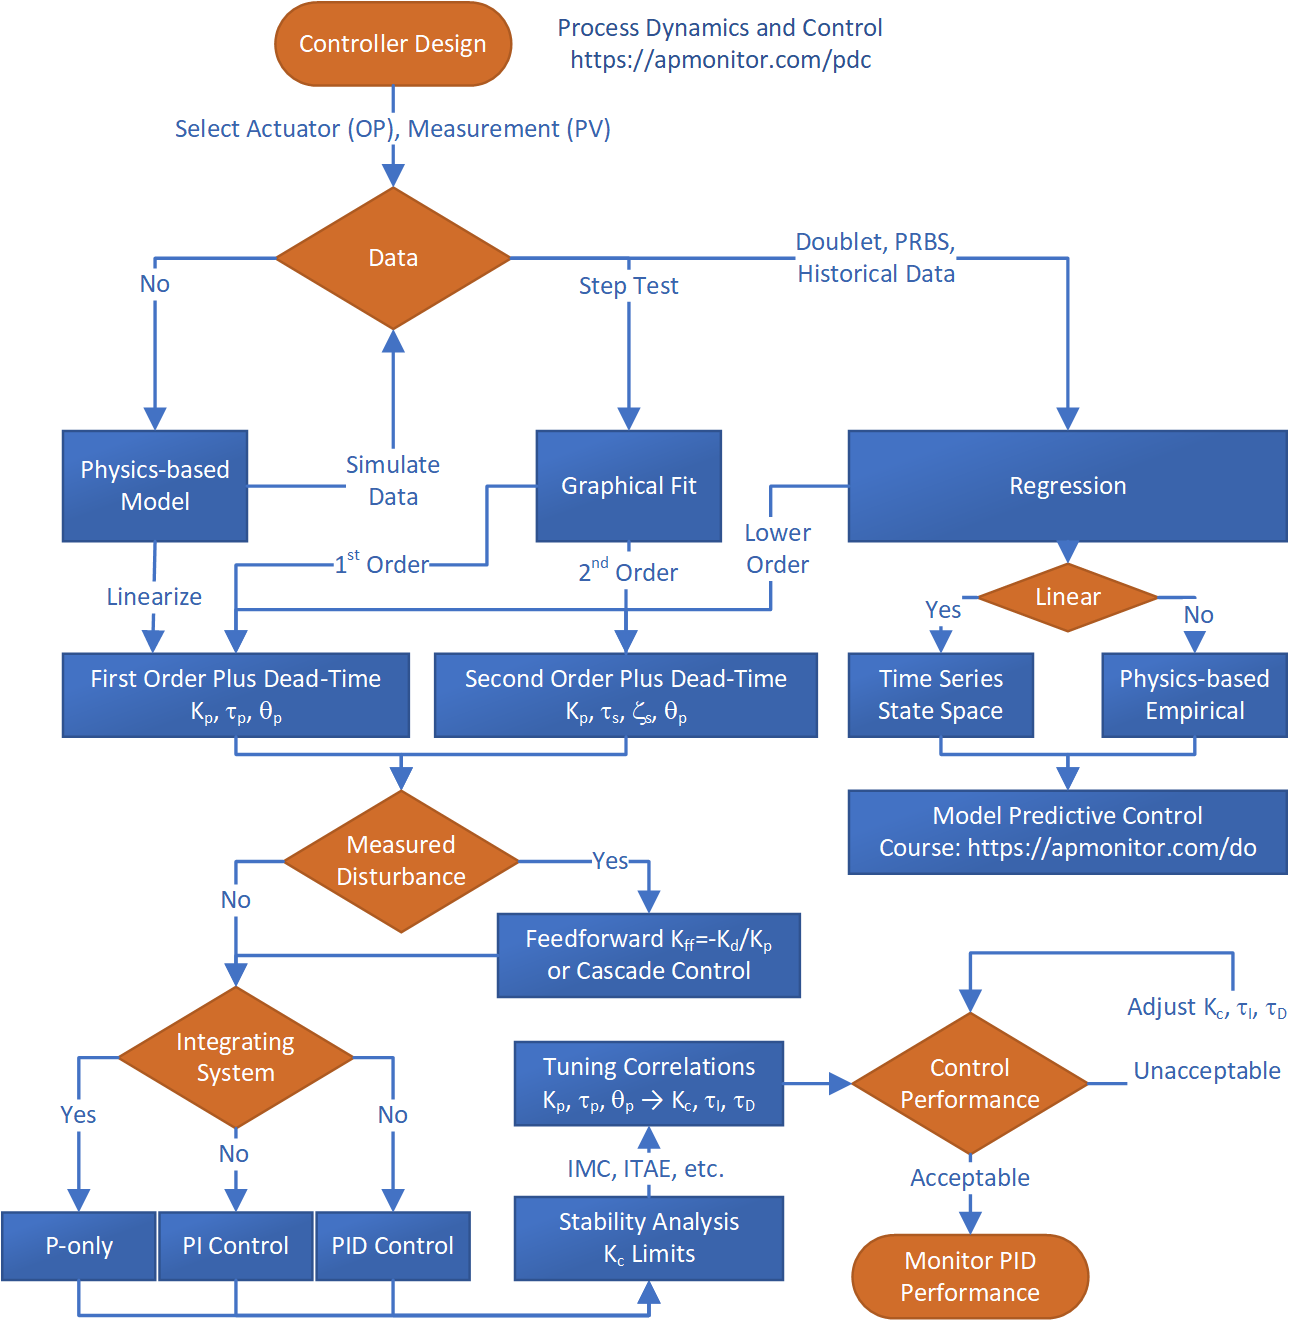

### Generate Step Test Data

Step tests with both heaters. Connect the TCLab to generate data from the hardware or unplug the TCLab to generate simulated data with 20x speedup.

In [ ]:
import numpy as np
import pandas as pd
import tclab
import time
import os.path

# generate step test data on Arduino
filename = 'data.csv'

# heater steps
Q1d = np.zeros(601)
Q1d[10:200] = 80
Q1d[200:280] = 20
Q1d[280:400] = 70
Q1d[400:] = 50

Q2d = np.zeros(601)
Q2d[120:320] = 100
Q2d[320:520] = 10
Q2d[520:] = 80

# Connect to Arduino or TCLab simulator
try:
    a = tclab.TCLab()
    hardware = True
    speedup = 1
except:
    hardware = False
    speedup = 20
    TCLab = tclab.setup(connected=False, speedup=speedup)
    a = TCLab()

fid = open(filename,'w')
fid.write('Time,Q1,Q2,T1,T2\n')
fid.close()

# run step test (10 min)
for i in range(601):
    start = time.time()
    # set heater values
    a.Q1(Q1d[i])
    a.Q2(Q2d[i])
    if i%10==0:
        # print every 10 cycles
        print('Time: ' + str(i) + \
              ' Q1: ' + str(Q1d[i]) + \
              ' Q2: ' + str(Q2d[i]) + \
              ' T1: ' + str(a.T1)   + \
              ' T2: ' + str(a.T2))
    # wait for 1 sec (real-time) or 0.05 sec (speedup=20x)
    end = time.time()
    time.sleep(max(0.01,1/speedup-(end-start)))
    fid = open(filename,'a')
    fid.write(str(i)+','+str(Q1d[i])+','+str(Q2d[i])+',' \
              +str(a.T1)+','+str(a.T2)+'\n')
    fid.close()
# close connection to Arduino
a.close()

### Plot Step Test Data

In [ ]:
import matplotlib.pyplot as plt

# read data file
filename = 'data.csv'
data = pd.read_csv(filename)

# plot measurements
plt.figure(figsize=(10,7))
plt.subplot(2,1,1)
plt.plot(data['Time'],data['Q1'],'r-',label='Heater 1')
plt.plot(data['Time'],data['Q2'],'b--',label='Heater 2')
plt.ylabel('Heater (%)')
plt.legend(loc='best')
plt.subplot(2,1,2)
plt.plot(data['Time'],data['T1'],'r.',label='Temperature 1')
plt.plot(data['Time'],data['T2'],'b.',label='Temperature 2')
plt.ylabel(r'Temperature ($^oC$)')
plt.legend(loc='best')
plt.xlabel('Time (sec)')
plt.savefig('data.png')
plt.show()

### Physics-based Model Prediction

In [ ]:
!pip install gekko

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from gekko import GEKKO
from scipy.integrate import odeint
from scipy.interpolate import interp1d

# Import data
try:
    # try to read local data file first
    filename = 'data.csv'
    data = pd.read_csv(filename)
except:
    filename = 'http://apmonitor.com/pdc/uploads/Main/tclab_data2.txt'
    data = pd.read_csv(filename)

# Fit Parameters of Energy Balance
m = GEKKO() # Create GEKKO Model

# Parameters to Estimate
U = m.FV(value=10,lb=1,ub=20)
Us = m.FV(value=20,lb=5,ub=40)
alpha1 = m.FV(value=0.01,lb=0.001,ub=0.03)  # W / % heater
alpha2 = m.FV(value=0.005,lb=0.001,ub=0.02) # W / % heater
tau = m.FV(value=10.0,lb=5.0,ub=60.0)

# Measured inputs
Q1 = m.Param()
Q2 = m.Param()

Ta =23.0+273.15                     # K
mass = 4.0/1000.0                   # kg
Cp = 0.5*1000.0                     # J/kg-K    
A = 10.0/100.0**2                   # Area not between heaters in m^2
As = 2.0/100.0**2                   # Area between heaters in m^2
eps = 0.9                           # Emissivity
sigma = 5.67e-8                     # Stefan-Boltzmann

TH1 = m.SV()
TH2 = m.SV()
TC1 = m.CV()
TC2 = m.CV()

# Heater Temperatures in Kelvin
T1 = m.Intermediate(TH1+273.15)
T2 = m.Intermediate(TH2+273.15)

# Heat transfer between two heaters
Q_C12 = m.Intermediate(Us*As*(T2-T1)) # Convective
Q_R12 = m.Intermediate(eps*sigma*As*(T2**4-T1**4)) # Radiative

# Energy balances
m.Equation(TH1.dt() == (1.0/(mass*Cp))*(U*A*(Ta-T1) \
                + eps * sigma * A * (Ta**4 - T1**4) \
                + Q_C12 + Q_R12 \
                + alpha1*Q1))

m.Equation(TH2.dt() == (1.0/(mass*Cp))*(U*A*(Ta-T2) \
                + eps * sigma * A * (Ta**4 - T2**4) \
                - Q_C12 - Q_R12 \
                + alpha2*Q2))

# Conduction to temperature sensors
m.Equation(tau*TC1.dt() == TH1-TC1)
m.Equation(tau*TC2.dt() == TH2-TC2)

# Options
# STATUS=1 allows solver to adjust parameter
U.STATUS = 1  
Us.STATUS = 1  
alpha1.STATUS = 1 
alpha2.STATUS = 1
tau.STATUS = 1

Q1.value=data['Q1'].values
Q2.value=data['Q2'].values
TH1.value=data['T1'].values[0]
TH2.value=data['T2'].values[0]
TC1.value=data['T1'].values
TC1.FSTATUS = 1    # minimize fstatus * (meas-pred)^2
TC2.value=data['T2'].values
TC2.FSTATUS = 1    # minimize fstatus * (meas-pred)^2

m.time = data['Time'].values
m.options.IMODE   = 5 # MHE
m.options.EV_TYPE = 2 # Objective type
m.options.NODES   = 2 # Collocation nodes
m.options.SOLVER  = 3 # IPOPT

m.solve(disp=False) # Solve

# Parameter values
print('U     : ' + str(U.value[0]))
print('Us     : ' + str(Us.value[0]))
print('alpha1: ' + str(alpha1.value[0]))
print('alpha2: ' + str(alpha2.value[-1]))
print('tau: ' + str(tau.value[0]))

sae = 0.0
for i in range(len(data)):
    sae += np.abs(data['T1'][i]-TC1.value[i])
    sae += np.abs(data['T2'][i]-TC2.value[i])
print('SAE Energy Balance: ' + str(sae))

# Create plot
plt.figure(figsize=(10,7))
ax=plt.subplot(2,1,1)
ax.grid()
plt.plot(data['Time'],data['T1'],'r.',label=r'$T_1$ measured')
plt.plot(m.time,TC1.value,color='black',linestyle='--',\
         linewidth=2,label=r'$T_1$ energy balance')
plt.plot(data['Time'],data['T2'],'b.',label=r'$T_2$ measured')
plt.plot(m.time,TC2.value,color='orange',linestyle='--',\
         linewidth=2,label=r'$T_2$ energy balance')
plt.ylabel(r'T ($^oC$)')
plt.legend(loc=2)
ax=plt.subplot(2,1,2)
ax.grid()
plt.plot(data['Time'],data['Q1'],'r-',\
         linewidth=3,label=r'$Q_1$')
plt.plot(data['Time'],data['Q2'],'b:',\
         linewidth=3,label=r'$Q_2$')
plt.ylabel('Heaters')
plt.xlabel('Time (sec)')
plt.legend(loc='best')
plt.savefig('Physics_fit.png')

### Determine FOPDT Parameters with Graphical Fit Widget

In [ ]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import ipywidgets as wg
from IPython.display import display

# try to read local data file first
try:
    filename = 'data.csv'
    data = pd.read_csv(filename)
except:
    filename = 'http://apmonitor.com/pdc/uploads/Main/tclab_data2.txt'
    data = pd.read_csv(filename)
    
n = 601 # time points to plot
tf = 600.0 # final time

# Use expected room temperature for initial condition
#y0 = [23.0,23.0]
# Use initial condition
y0d = [data['T1'].values[0],data['T2'].values[0]]

# load data
Q1 = data['Q1'].values
Q2 = data['Q2'].values
T1 = data['T1'].values
T2 = data['T2'].values
T1p = np.ones(n)*y0d[0]
T2p = np.ones(n)*y0d[1]

def process(y,t,u1,u2,Kp,Kd,taup):
    y1,y2 = y
    dy1dt = (1.0/taup) * (-(y1-y0d[0]) + Kp * u1 + Kd * (y2-y1))
    dy2dt = (1.0/taup) * (-(y2-y0d[1]) + (Kp/2.0) * u2 + Kd * (y1-y2))
    return [dy1dt,dy2dt]

def fopdtPlot(Kp,Kd,taup,thetap):
    y0 = y0d
    t = np.linspace(0,tf,n) # create time vector
    iae = 0.0
    # loop through all time steps
    for i in range(1,n):
        # simulate process for one time step
        ts = [t[i-1],t[i]]         # time interval
        inputs = (Q1[max(0,i-int(thetap))],Q2[max(0,i-int(thetap))],Kp,Kd,taup)
        y = odeint(process,y0,ts,args=inputs)
        y0 = y[1]                  # record new initial condition
        T1p[i] = y0[0]
        T2p[i] = y0[1]        
        iae += np.abs(T1[i]-T1p[i]) + np.abs(T2[i]-T2p[i])

    # plot FOPDT response
    plt.figure(1,figsize=(15,7))
    plt.subplot(2,1,1)
    plt.plot(t,T1,'r.',linewidth=2,label='Temperature 1 (meas)')
    plt.plot(t,T2,'b.',linewidth=2,label='Temperature 2 (meas)')
    plt.plot(t,T1p,'r--',linewidth=2,label='Temperature 1 (pred)')
    plt.plot(t,T2p,'b--',linewidth=2,label='Temperature 2 (pred)')
    plt.ylabel(r'T $(^oC)$')
    plt.text(200,20,'Integral Abs Error: ' + str(np.round(iae,2)))
    plt.text(400,35,r'$K_p$: ' + str(np.round(Kp,0)))  
    plt.text(400,30,r'$K_d$: ' + str(np.round(Kd,0)))  
    plt.text(400,25,r'$\tau_p$: ' + str(np.round(taup,0)) + ' sec')  
    plt.text(400,20,r'$\theta_p$: ' + str(np.round(thetap,0)) + ' sec')  
    plt.legend(loc=2)
    plt.subplot(2,1,2)
    plt.plot(t,Q1,'b--',linewidth=2,label=r'Heater 1 ($Q_1$)')
    plt.plot(t,Q2,'r:',linewidth=2,label=r'Heater 2 ($Q_2$)')
    plt.legend(loc='best')
    plt.xlabel('time (sec)')

Kp_slide = wg.FloatSlider(value=0.5,min=0.1,max=1.5,step=0.05)
Kd_slide = wg.FloatSlider(value=0.0,min=0.0,max=1.0,step=0.05)
taup_slide = wg.FloatSlider(value=50.0,min=50.0,max=250.0,step=5.0)
thetap_slide = wg.FloatSlider(value=0,min=0,max=30,step=1)
wg.interact(fopdtPlot, Kp=Kp_slide, Kd=Kd_slide, taup=taup_slide,thetap=thetap_slide)
print('FOPDT Simulator: Adjust Kp, Kd, taup, and thetap ' + \
      'to achieve lowest Integral Abs Error')

### Determine FOPDT Parameters with Optimization

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.interpolate import interp1d

# initial guesses
x0 = np.zeros(4)
x0[0] = 0.8 # Kp
x0[1] = 0.2 # Kd
x0[2] = 150.0 # taup
x0[3] = 10.0 # thetap

# Import CSV data file
# try to read local data file first
try:
    filename = 'data.csv'
    data = pd.read_csv(filename)
except:
    filename = 'http://apmonitor.com/pdc/uploads/Main/tclab_data2.txt'
    data = pd.read_csv(filename)
Q1_0 = data['Q1'].values[0]
Q2_0 = data['Q2'].values[0]
T1_0 = data['T1'].values[0]
T2_0 = data['T2'].values[0]
t = data['Time'].values - data['Time'].values[0]
Q1 = data['Q1'].values
Q2 = data['Q2'].values
T1 = data['T1'].values
T2 = data['T2'].values

# specify number of steps
ns = len(t)
delta_t = t[1]-t[0]
# create linear interpolation of the u data versus time
Qf1 = interp1d(t,Q1)
Qf2 = interp1d(t,Q2)

# define first-order plus dead-time approximation    
def fopdt(T,t,Qf1,Qf2,Kp,Kd,taup,thetap):
    #  T      = states
    #  t      = time
    #  Qf1    = input linear function (for time shift)
    #  Qf2    = input linear function (for time shift)
    #  Kp     = model gain
    #  Kd     = disturbance gain
    #  taup   = model time constant
    #  thetap = model time constant
    # time-shift Q
    try:
        if (t-thetap) <= 0:
            Qm1 = Qf1(0.0)
            Qm2 = Qf2(0.0)
        else:
            Qm1 = Qf1(t-thetap)
            Qm2 = Qf2(t-thetap)
    except:
        Qm1 = Q1_0
        Qm2 = Q2_0
    # calculate derivative
    dT1dt = (-(T[0]-T1_0) + Kp*(Qm1-Q1_0) + Kd*(T[1]-T[0]))/taup
    dT2dt = (-(T[1]-T2_0) + (Kp/2.0)*(Qm2-Q2_0) + Kd*(T[0]-T[1]))/taup
    return [dT1dt,dT2dt]

# simulate FOPDT model
def sim_model(x):
    # input arguments
    Kp,Kd,taup,thetap = x
    # storage for model values
    T1p = np.ones(ns) * T1_0
    T2p = np.ones(ns) * T2_0
    # loop through time steps    
    for i in range(0,ns-1):
        ts = [t[i],t[i+1]]
        T = odeint(fopdt,[T1p[i],T2p[i]],ts,args=(Qf1,Qf2,Kp,Kd,taup,thetap))
        T1p[i+1] = T[-1,0]
        T2p[i+1] = T[-1,1]
    return T1p,T2p

# define objective
def objective(x):
    # simulate model
    T1p,T2p = sim_model(x)
    # return objective
    return sum(np.abs(T1p-T1)+np.abs(T2p-T2))

# show initial objective
print('Initial SSE Objective: ' + str(objective(x0)))
print('Optimizing Values...')

# optimize without parameter constraints
#solution = minimize(objective,x0)

# optimize with bounds on variables
bnds = ((0.4, 1.5), (0.1, 0.5), (50.0, 200.0), (0.0, 30.0))
solution = minimize(objective,x0,bounds=bnds,method='SLSQP')

# show final objective
x = solution.x
iae = objective(x)
Kp,Kd,taup,thetap = x
print('Final SSE Objective: ' + str(objective(x)))
print('Kp: ' + str(Kp))
print('Kd: ' + str(Kd))
print('taup: ' + str(taup))
print('thetap: ' + str(thetap))
# save fopdt.txt file
fid = open('fopdt.txt','w')
fid.write(str(Kp)+'\n')
fid.write(str(Kd)+'\n')
fid.write(str(taup)+'\n')
fid.write(str(thetap)+'\n')
fid.write(str(T1_0)+'\n')
fid.write(str(T2_0)+'\n')
fid.close()

# calculate model with updated parameters
T1p,T2p = sim_model(x)

plt.figure(1,figsize=(15,7))
plt.subplot(2,1,1)
plt.plot(t,T1,'r.',linewidth=2,label='Temperature 1 (meas)')
plt.plot(t,T2,'b.',linewidth=2,label='Temperature 2 (meas)')
plt.plot(t,T1p,'r--',linewidth=2,label='Temperature 1 (pred)')
plt.plot(t,T2p,'b--',linewidth=2,label='Temperature 2 (pred)')
plt.ylabel(r'T $(^oC)$')
plt.text(200,20,'Integral Abs Error: ' + str(np.round(iae,2)))
plt.text(400,35,r'$K_p$: ' + str(np.round(Kp,1)))  
plt.text(400,30,r'$K_d$: ' + str(np.round(Kd,1)))  
plt.text(400,25,r'$\tau_p$: ' + str(np.round(taup,0)) + ' sec')  
plt.text(400,20,r'$\theta_p$: ' + str(np.round(thetap,0)) + ' sec')  
plt.legend(loc=2)
plt.subplot(2,1,2)
plt.plot(t,Q1,'b--',linewidth=2,label=r'Heater 1 ($Q_1$)')
plt.plot(t,Q2,'r:',linewidth=2,label=r'Heater 2 ($Q_2$)')
plt.legend(loc='best')
plt.xlabel('time (sec)')
plt.savefig('fopdt_opt.png')
plt.show()

### Design 2 PID Controllers for T1 and T2

In [ ]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import ipywidgets as wg
from IPython.display import display

n = 601 # time points to plot
tf = 600.0 # final time

# Load TCLab FOPDT
fid = open('fopdt.txt','r')
Kp = float(fid.readline())
Kd = float(fid.readline())
taup = float(fid.readline())
thetap = float(fid.readline())
T1_0 = float(fid.readline())
T2_0 = float(fid.readline())
fid.close()
y0 = [T1_0,T2_0]
Kff = -Kp/Kd

def process(y,t,u1,u2):
    y1,y2 = y
    dy1dt = (1.0/taup) * (-(y1-y0[0]) + Kp * u1 + Kd * (y2-y1))
    dy2dt = (1.0/taup) * (-(y2-y0[1]) + (Kp/2.0) * u2 + Kd * (y1-y2))
    return [dy1dt,dy2dt]

def pidPlot(Kc,tauI,tauD,Kff):
    y0 = [23.0,23.0]
    t = np.linspace(0,tf,n) # create time vector
    P1 = np.zeros(n)         # initialize proportional term
    I1 = np.zeros(n)         # initialize integral term
    D1 = np.zeros(n)         # initialize derivative term
    FF1 = np.zeros(n)        # initialize feedforward term
    e1 = np.zeros(n)         # initialize error
    P2 = np.zeros(n)         # initialize proportional term
    I2 = np.zeros(n)         # initialize integral term
    D2 = np.zeros(n)         # initialize derivative term
    FF2 = np.zeros(n)        # initialize feedforward term
    e2 = np.zeros(n)         # initialize error
    OP1 = np.zeros(n)       # initialize controller output
    OP2 = np.zeros(n)       # initialize disturbance
    PV1 = np.ones(n)*y0[0]  # initialize process variable
    PV2 = np.ones(n)*y0[1]  # initialize process variable
    SP1 = np.ones(n)*y0[0]  # initialize setpoint
    SP2 = np.ones(n)*y0[1]  # initialize setpoint
    SP1[10:] = 60.0         # step up
    SP1[400:] = 40.0         # step up
    SP2[150:] = 50.0        # step down
    SP2[350:] = 35.0        # step down
    Kc1 = Kc
    Kc2 = Kc*2.0
    Kff1 = Kff
    Kff2 = Kff*2.0
    iae = 0.0
    # loop through all time steps
    for i in range(1,n):
        # simulate process for one time step
        ts = [t[i-1],t[i]]         # time interval
        heaters = (OP1[max(0,i-int(thetap))],OP2[max(0,i-int(thetap))])
        y = odeint(process,y0,ts,args=heaters)
        y0 = y[1]                  # record new initial condition
        # calculate new OP with PID
        PV1[i] = y[1][0]              # record T1 PV
        PV2[i] = y[1][1]              # record T2 PV
        iae += np.abs(SP1[i]-PV1[i]) + np.abs(SP2[i]-PV2[i])
        dt = t[i] - t[i-1]         # calculate time step
        
        # PID for loop 1
        e1[i] = SP1[i] - PV1[i]       # calculate error = SP - PV
        P1[i] = Kc1 * e1[i]           # calculate proportional term
        I1[i] = I1[i-1] + (Kc1/tauI) * e1[i] * dt  # calculate integral term
        D1[i] = -Kc * tauD * (PV1[i]-PV1[i-1])/dt # calculate derivative
        FF1[i] = Kff1 * (PV2[i]-PV1[i])
        OP1[i] = P1[i] + I1[i] + D1[i] + FF1[i] # calculate new output
        if OP1[i]>=100:
            OP1[i] = 100.0
            I1[i] = I1[i-1] # reset integral
        if OP1[i]<=0:
            OP1[i] = 0.0
            I1[i] = I1[i-1] # reset integral            

        # PID for loop 2
        e2[i] = SP2[i] - PV2[i]       # calculate error = SP - PV
        P2[i] = Kc2 * e2[i]           # calculate proportional term
        I2[i] = I2[i-1] + (Kc2/tauI) * e2[i] * dt  # calculate integral term
        D2[i] = -Kc2 * tauD * (PV2[i]-PV2[i-1])/dt # calculate derivative
        FF2[i] = Kff2 * (PV1[i]-PV2[i])
        OP2[i] = P2[i] + I2[i] + D2[i] + FF2[i] # calculate new output
        if OP2[i]>=100:
            OP2[i] = 100.0
            I2[i] = I2[i-1] # reset integral
        if OP2[i]<=0:
            OP2[i] = 0.0
            I2[i] = I2[i-1] # reset integral            
            
    # plot PID response
    plt.figure(1,figsize=(15,7))
    plt.subplot(2,2,1)
    plt.plot(t,SP1,'k-',linewidth=2,label='Setpoint 1 (SP)')
    plt.plot(t,PV1,'r:',linewidth=2,label='Temperature 1 (PV)')
    plt.ylabel(r'T $(^oC)$')
    plt.text(100,35,'Integral Abs Error: ' + str(np.round(iae,2)))
    plt.text(400,35,r'$K_{c1}$: ' + str(np.round(Kc,1)))  
    plt.text(400,30,r'$\tau_I$: ' + str(np.round(tauI,0)) + ' sec')  
    plt.text(400,25,r'$\tau_D$: ' + str(np.round(tauD,0)) + ' sec')  
    plt.text(400,20,r'$K_{ff}$: ' + str(np.round(Kff1,2)))  
    plt.ylim([15,70])
    plt.legend(loc=1)
    plt.subplot(2,2,2)
    plt.plot(t,SP2,'k-',linewidth=2,label='Setpoint 2 (SP)')
    plt.plot(t,PV2,'r:',linewidth=2,label='Temperature 2 (PV)')
    plt.ylabel(r'T $(^oC)$')
    plt.text(20,65,r'$K_{c2}$: ' + str(np.round(Kc*2,1)))  
    plt.text(20,60,r'$\tau_I$: ' + str(np.round(tauI,0)) + ' sec')  
    plt.text(20,55,r'$\tau_D$: ' + str(np.round(tauD,0)) + ' sec')  
    plt.text(20,50,r'$K_{ff}$: ' + str(np.round(Kff2,2)))
    plt.ylim([15,70])
    plt.legend(loc=1)
    plt.subplot(2,2,3)
    plt.plot(t,OP1,'b--',linewidth=2,label='Heater 1 (OP)')
    plt.legend(loc='best')
    plt.xlabel('time (sec)')
    plt.subplot(2,2,4)
    plt.plot(t,OP2,'b--',linewidth=2,label='Heater 2 (OP)')
    plt.legend(loc='best')
    plt.xlabel('time (sec)')

print('PID with Feedforward Simulator: Adjust Kc, tauI, tauD, and Kff ' + \
      'to achieve lowest Integral Abs Error')

# ITAE Setpoint Tracking PI Tuning
Kc = (0.586/Kp)*(thetap/taup)**(-0.916); tauI = taup/(1.03-0.165*(thetap/taup))
print(f'ITAE Recommended: Kc={Kc:4.2f}, tauI={tauI:5.1f}, tauD=0, Kff={Kff:4.2f}')

# IMC Aggressive PID Tuning
tauc = max(0.1*taup,0.8*thetap); Kc = (1/Kp)*(taup+0.5*taup)/(tauc+0.5*thetap)
tauI = taup+0.5*thetap; tauD = taup*thetap/(2*taup+thetap); Kff=-Kd/Kp
print(f'IMC Recommended: Kc={Kc:4.2f}, tauI={tauI:5.1f}, tauD={tauD:4.2f}, Kff={Kff:4.2f}')

Kc_slide = wg.FloatSlider(value=Kc,min=0.0,max=50.0,step=1.0)
tauI_slide = wg.FloatSlider(value=tauI,min=20.0,max=250.0,step=1.0)
tauD_slide = wg.FloatSlider(value=tauD,min=0.0,max=20.0,step=1.0)
Kff_slide = wg.FloatSlider(value=Kff,min=-0.5,max=0.5,step=0.1)
wg.interact(pidPlot, Kc=Kc_slide, tauI=tauI_slide, tauD=tauD_slide,Kff=Kff_slide)
print('')

### Test Interacting PID Controllers with TCLab

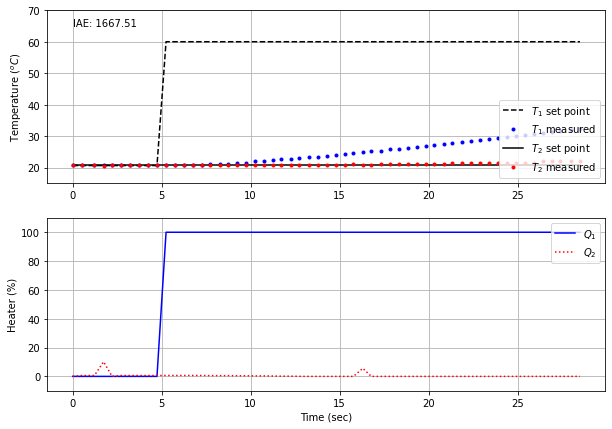

In [ ]:
import tclab
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.integrate import odeint

#-----------------------------------------
# PID controller performance for the TCLab
#-----------------------------------------
# PID Parameters
Kc   = 5.0
tauI = 120.0 # sec
tauD = 2.0   # sec
Kff  = -0.3

# Animate Plot?
animate = True
if animate:
    try:
        from IPython import get_ipython
        from IPython.display import display,clear_output
        get_ipython().run_line_magic('matplotlib', 'inline')
        ipython = True
        print('IPython Notebook')
    except:
        ipython = False
        print('Not IPython Notebook')

#-----------------------------------------
# PID Controller with Feedforward
#-----------------------------------------
# inputs ---------------------------------
# sp = setpoint
# pv = current temperature
# pv_last = prior temperature
# ierr = integral error
# dt = time increment between measurements
# outputs --------------------------------
# op = output of the PID controller
# P = proportional contribution
# I = integral contribution
# D = derivative contribution
def pid(sp,pv,pv_last,ierr,dt,d,cid):
    # Parameters in terms of PID coefficients
    if cid==1:
        # controller 1
        KP = Kc
        Kf = Kff
    else:
        # controller 2
        KP = Kc * 2.0
        Kf = Kff * 2.0
    KI = Kc/tauI
    KD = Kc*tauD

    # ubias for controller (initial heater)
    op0 = 0 
    # upper and lower bounds on heater level
    ophi = 100
    oplo = 0
    # calculate the error
    error = sp-pv
    # calculate the integral error
    ierr = ierr + KI * error * dt
    # calculate the measurement derivative
    dpv = (pv - pv_last) / dt
    # calculate the PID output
    P = KP * error
    I = ierr
    D = -KD * dpv
    FF = Kff * d
    op = op0 + P + I + D + FF
    # implement anti-reset windup
    if op < oplo or op > ophi:
        I = I - KI * error * dt
        # clip output
        op = max(oplo,min(ophi,op))
    # return the controller output and PID terms
    return [op,P,I,D,FF]

# save txt file with data and set point
# t = time
# u1,u2 = heaters
# y1,y2 = tempeatures
# sp1,sp2 = setpoints
def save_txt(t, u1, u2, y1, y2, sp1, sp2):
    data = np.vstack((t, u1, u2, y1, y2, sp1, sp2))  # vertical stack
    data = data.T  # transpose data
    top = ('Time,Q1,Q2,T1,T2,TSP1,TSP2')
    np.savetxt('validate.txt', data, delimiter=',',\
               header=top, comments='')

# Connect to Arduino or TCLab simulator
try:
    a = tclab.TCLab()
    hardware = True
    speedup = 1
except:
    hardware = False
    speedup = 2
    TCLab = tclab.setup(connected=False, speedup=speedup)
    a = TCLab()

# Wait until temperature is below 25 degC
if hardware:
    print('Check that temperatures are < 25 degC before starting')
    i = 0
    while a.T1>=25.0 or a.T2>=25.0:
        print(f'Time: {i} T1: {a.T1} T2: {a.T2}')
        i += 10
        time.sleep(10)

# Turn LED on
print('LED On')
a.LED(100)

# Run time in minutes
run_time = 10.0

# Number of cycles
loops = int(60.0*run_time)
tm = np.zeros(loops)

# Heater set point steps
Tsp1 = np.ones(loops) * a.T1
Tsp2 = np.ones(loops) * a.T2 # set point (degC)
Tsp1[10:] = 60.0         # step up
Tsp1[400:] = 40.0        # step down
Tsp2[150:] = 50.0        # step up
Tsp2[350:] = 35.0        # step down

T1 = np.ones(loops) * a.T1 # measured T (degC)
T2 = np.ones(loops) * a.T2 # measured T (degC)

# impulse tests (0 - 100%)
Q1 = np.ones(loops) * 0.0
Q2 = np.ones(loops) * 0.0

if not animate:
    print('Running Main Loop. Ctrl-C to end.')
    print('  Time    SP1    PV1     Q1    SP2    PV2     Q2    IAE')
    print(('{:6.1f} {:6.2f} {:6.2f} ' + \
           '{:6.2f} {:6.2f} {:6.2f} {:6.2f} {:6.2f}').format( \
               tm[0],Tsp1[0],T1[0],Q1[0],Tsp2[0],T2[0],Q2[0],0.0))

# Main Loop
start_time = time.time()
prev_time = start_time
dt_error = 0.0
# Integral error
ierr1 = 0.0
ierr2 = 0.0
# Integral absolute error
iae = 0.0

if not ipython:
    plt.figure(figsize=(10,7))
    plt.ion()
    plt.show()

try:
    for i in range(1,loops):
        # Sleep time
        sleep_max = 1.0/speedup
        sleep = sleep_max - (time.time() - prev_time) - dt_error
        if sleep>=1e-4:
            time.sleep(sleep-1e-4)
        else:
            print('exceeded max cycle time by ' + str(abs(sleep)) + ' sec')
            time.sleep(1e-4)

        # Record time and change in time
        t = time.time()
        dt = t - prev_time
        if (sleep>=1e-4):
            dt_error = dt-sleep_max+0.009
        else:
            dt_error = 0.0
        prev_time = t
        tm[i] = t - start_time

        # Read temperatures in Kelvin 
        T1[i] = a.T1
        T2[i] = a.T2

        # Disturbances
        d1 = T1[i] - 23.0
        d2 = T2[i] - 23.0

        # Integral absolute error
        iae += np.abs(Tsp1[i]-T1[i]) + np.abs(Tsp2[i]-T2[i])

        # Calculate PID output
        [Q1[i],P,ierr1,D,FF] = pid(Tsp1[i],T1[i],T1[i-1],ierr1,dt,d2,1)
        [Q2[i],P,ierr2,D,FF] = pid(Tsp2[i],T2[i],T2[i-1],ierr2,dt,d1,2)

        # Write output (0-100)
        a.Q1(Q1[i])
        a.Q2(Q2[i])

        if not animate:
            # Print line of data
            print(('{:6.1f} {:6.2f} {:6.2f} ' + \
                  '{:6.2f} {:6.2f} {:6.2f} {:6.2f} {:6.2f}').format( \
                      tm[i],Tsp1[i],T1[i],Q1[i],Tsp2[i],T2[i],Q2[i],iae))
        else:
            if ipython:
                plt.figure(figsize=(10,7))
            else:
                plt.clf()
            # Update plot
            ax=plt.subplot(2,1,1)
            ax.grid()
            plt.plot(tm[0:i],Tsp1[0:i],'k--',label=r'$T_1$ set point')
            plt.plot(tm[0:i],T1[0:i],'b.',label=r'$T_1$ measured')
            plt.plot(tm[0:i],Tsp2[0:i],'k-',label=r'$T_2$ set point')
            plt.plot(tm[0:i],T2[0:i],'r.',label=r'$T_2$ measured')
            plt.ylabel(r'Temperature ($^oC$)')
            plt.text(0,65,'IAE: ' + str(np.round(iae,2)))
            plt.legend(loc=4)
            plt.ylim([15,70])
            ax=plt.subplot(2,1,2)
            ax.grid()
            plt.plot(tm[0:i],Q1[0:i],'b-',label=r'$Q_1$')
            plt.plot(tm[0:i],Q2[0:i],'r:',label=r'$Q_2$')
            plt.ylim([-10,110])
            plt.ylabel('Heater (%)')
            plt.legend(loc=1)
            plt.xlabel('Time (sec)')
            if ipython:
                clear_output(wait=True)
                display(plt.gcf())
            else:
                plt.draw()
                plt.pause(0.05)

    # Turn off heaters
    a.Q1(0)
    a.Q2(0)
    a.close()
    # Save text file
    save_txt(tm,Q1,Q2,T1,T2,Tsp1,Tsp2)
    # Save Plot
    if not animate:
        plt.figure(figsize=(10,7))
        ax=plt.subplot(2,1,1)
        ax.grid()
        plt.plot(tm,Tsp1,'k--',label=r'$T_1$ set point')
        plt.plot(tm,T1,'b.',label=r'$T_1$ measured')
        plt.plot(tm,Tsp2,'k-',label=r'$T_2$ set point')
        plt.plot(tm,T2,'r.',label=r'$T_2$ measured')
        plt.ylabel(r'Temperature ($^oC$)')
        plt.text(0,65,'IAE: ' + str(np.round(iae,2)))
        plt.legend(loc=4)
        ax=plt.subplot(2,1,2)
        ax.grid()
        plt.plot(tm,Q1,'b-',label=r'$Q_1$')
        plt.plot(tm,Q2,'r:',label=r'$Q_2$')
        plt.ylabel('Heater (%)')
        plt.legend(loc=1)
        plt.xlabel('Time (sec)')
    plt.savefig('PID_Control.png')

# Allow user to end loop with Ctrl-C           
except KeyboardInterrupt:
    # Disconnect from Arduino
    a.Q1(0)
    a.Q2(0)
    print('Shutting down')
    a.close()
    save_txt(tm[0:i],Q1[0:i],Q2[0:i],T1[0:i],T2[0:i],Tsp1[0:i],Tsp2[0:i])
    plt.savefig('PID_Control.png')

# Make sure serial connection closes with an error
except:           
    # Disconnect from Arduino
    a.Q1(0)
    a.Q2(0)
    print('Error: Shutting down')
    a.close()
    save_txt(tm[0:i],Q1[0:i],Q2[0:i],T1[0:i],T2[0:i],Tsp1[0:i],Tsp2[0:i])
    plt.savefig('PID_Control.png')
    raise

print('PID test complete')
print('Kc: ' + str(Kc))
print('tauI: ' + str(tauI))
print('tauD: ' + str(tauD))
print('Kff: ' + str(Kff))